In [8]:
pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-05-21 17:39:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-21 17:39:31 (109 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [11]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!unzip /content/drive/MyDrive/Capstone/sea_creature.zip -d/content/sea_creature

Streaming output truncated to the last 5000 lines.
  inflating: /content/sea_creature/Seahorse/9891995103_849905035f_o.jpg  
  inflating: /content/sea_creature/Seahorse/9984393_fb8ac77d6a_o.jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (1).jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (10).jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (11).jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (12).jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (13).jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (14).jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (15).jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (16).jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (17).jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (18).jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (19).jpg  
  inflating: /content/sea_creature/Seahorse/Sea Horse (2).jpg  
  inflating: /content/sea_

In [14]:
# Walk through each directory
dataset = "/content/sea_creature"
walk_through_dir(dataset)

There are 23 directories and 0 images in '/content/sea_creature'.
There are 0 directories and 499 images in '/content/sea_creature/Crabs'.
There are 0 directories and 482 images in '/content/sea_creature/Penguin'.
There are 0 directories and 500 images in '/content/sea_creature/Nudibranchs'.
There are 0 directories and 562 images in '/content/sea_creature/Octopus'.
There are 0 directories and 782 images in '/content/sea_creature/Dolphin'.
There are 0 directories and 845 images in '/content/sea_creature/Jelly Fish'.
There are 0 directories and 500 images in '/content/sea_creature/Corals'.
There are 0 directories and 1903 images in '/content/sea_creature/Turtle_Tortoise'.
There are 0 directories and 500 images in '/content/sea_creature/Otter'.
There are 0 directories and 517 images in '/content/sea_creature/Sea Rays'.
There are 0 directories and 499 images in '/content/sea_creature/Starfish'.
There are 0 directories and 531 images in '/content/sea_creature/Puffers'.
There are 0 directori

In [15]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [34]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/content/sea_creature").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [35]:
image_df

Filepath  Label
0      /content/sea_creature/Crabs/24006208902_a43e76...  Crabs
1      /content/sea_creature/Crabs/494388691_d04b368b...  Crabs
2      /content/sea_creature/Crabs/6066278765_74cf43d...  Crabs
3      /content/sea_creature/Crabs/5519272999_1ffc9a0...  Crabs
4      /content/sea_creature/Crabs/11739969856_8b38ff...  Crabs
...                                                  ...    ...
13706  /content/sea_creature/Whale/26230145276_f36d16...  Whale
13707  /content/sea_creature/Squid/29237238000_12071f...  Squid
13708  /content/sea_creature/Squid/30013610722_7549de...  Squid
13709  /content/sea_creature/Squid/7325654802_3f71681...  Squid
13710  /content/sea_creature/Fish/14232183698_9699751...   Fish

[13711 rows x 2 columns]

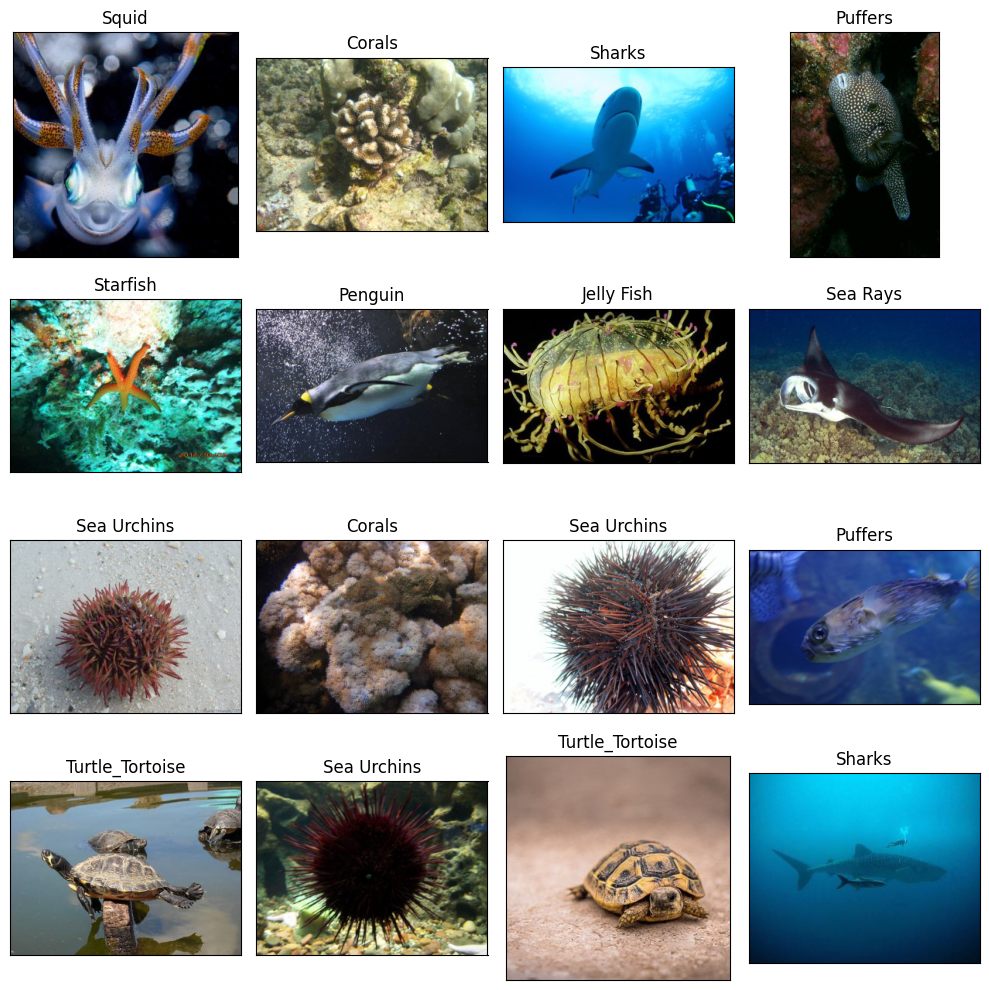

In [36]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [38]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

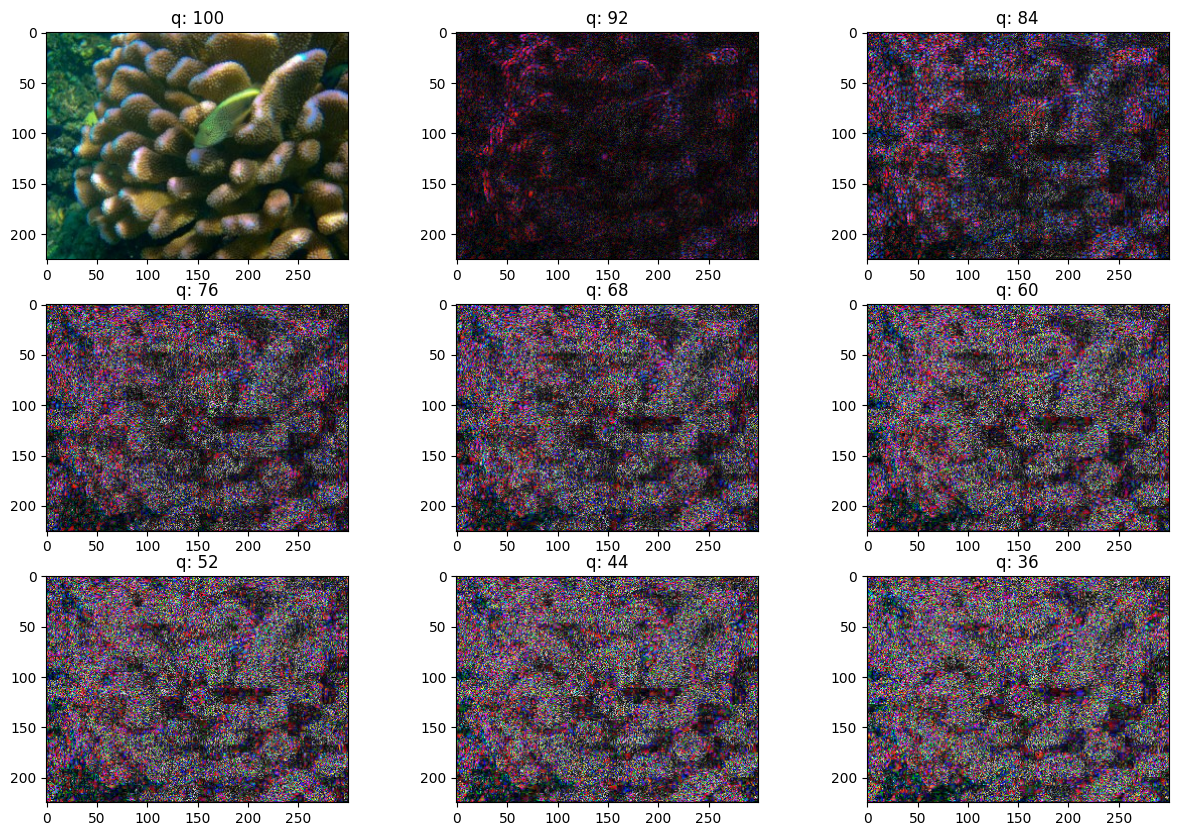

In [39]:
# View random sample from the dataset
p = random_sample('/content/sea_creature/Corals')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [40]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [41]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [42]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 8775 validated image filenames belonging to 23 classes.
Found 2193 validated image filenames belonging to 23 classes.
Found 2743 validated image filenames belonging to 23 classes.


In [43]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [44]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [45]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [46]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [52]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(23, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "animal_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/animal_classification/20230521-181531
Epoch 1/100
275/275 [==============================] - 41s 127ms/step - loss: 3.2409 - accuracy: 0.0858 - val_loss: 2.8060 - val_accuracy: 0.2093
Epoch 2/100
275/275 [==============================] - 32s 117ms/step - loss: 2.7383 - accuracy: 0.2293 - val_loss: 2.4050 - val_accuracy: 0.3484
Epoch 3/100
275/275 [==============================] - 33s 119ms/step - loss: 2.3906 - accuracy: 0.3381 - val_loss: 2.0745 - val_accuracy: 0.4902
Epoch 4/100
275/275 [==============================] - 33s 121ms/step - loss: 2.0938 - accuracy: 0.4385 - val_loss: 1.7969 - val_accuracy: 0.5718
Epoch 5/100
275/275 [==============================] - 38s 138ms/step - loss: 1.8507 - accuracy: 0.5118 - val_loss: 1.5716 - val_accuracy: 0.6243
Epoch 6/100
275/275 [==============================] - 41s 148ms/step - loss: 1.6639 - accuracy: 0.5556 - val_loss: 1.3929 - val_accuracy: 0.6607
Epoch 7/100
275/275 [==================

In [53]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.61392
Test Accuracy: 82.21%


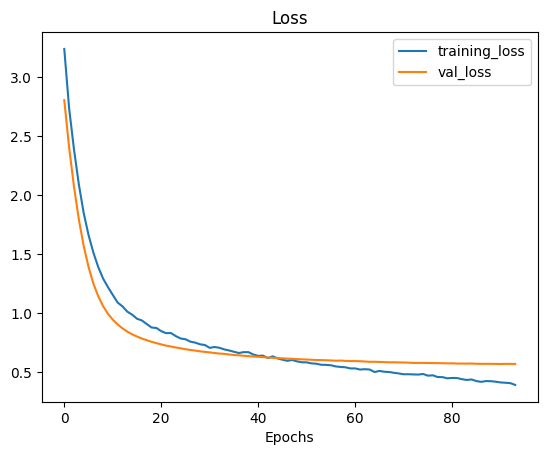

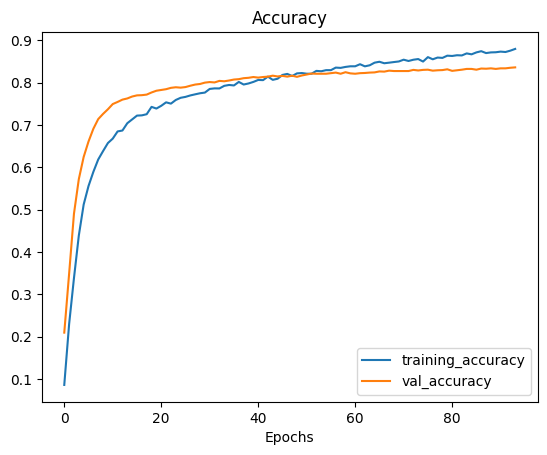

In [54]:
plot_loss_curves(history)

In [55]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

86/86 [==============================] - 9s 93ms/step
The first 5 predictions: ['Puffers', 'Squid', 'Fish', 'Sea Urchins', 'Dolphin']


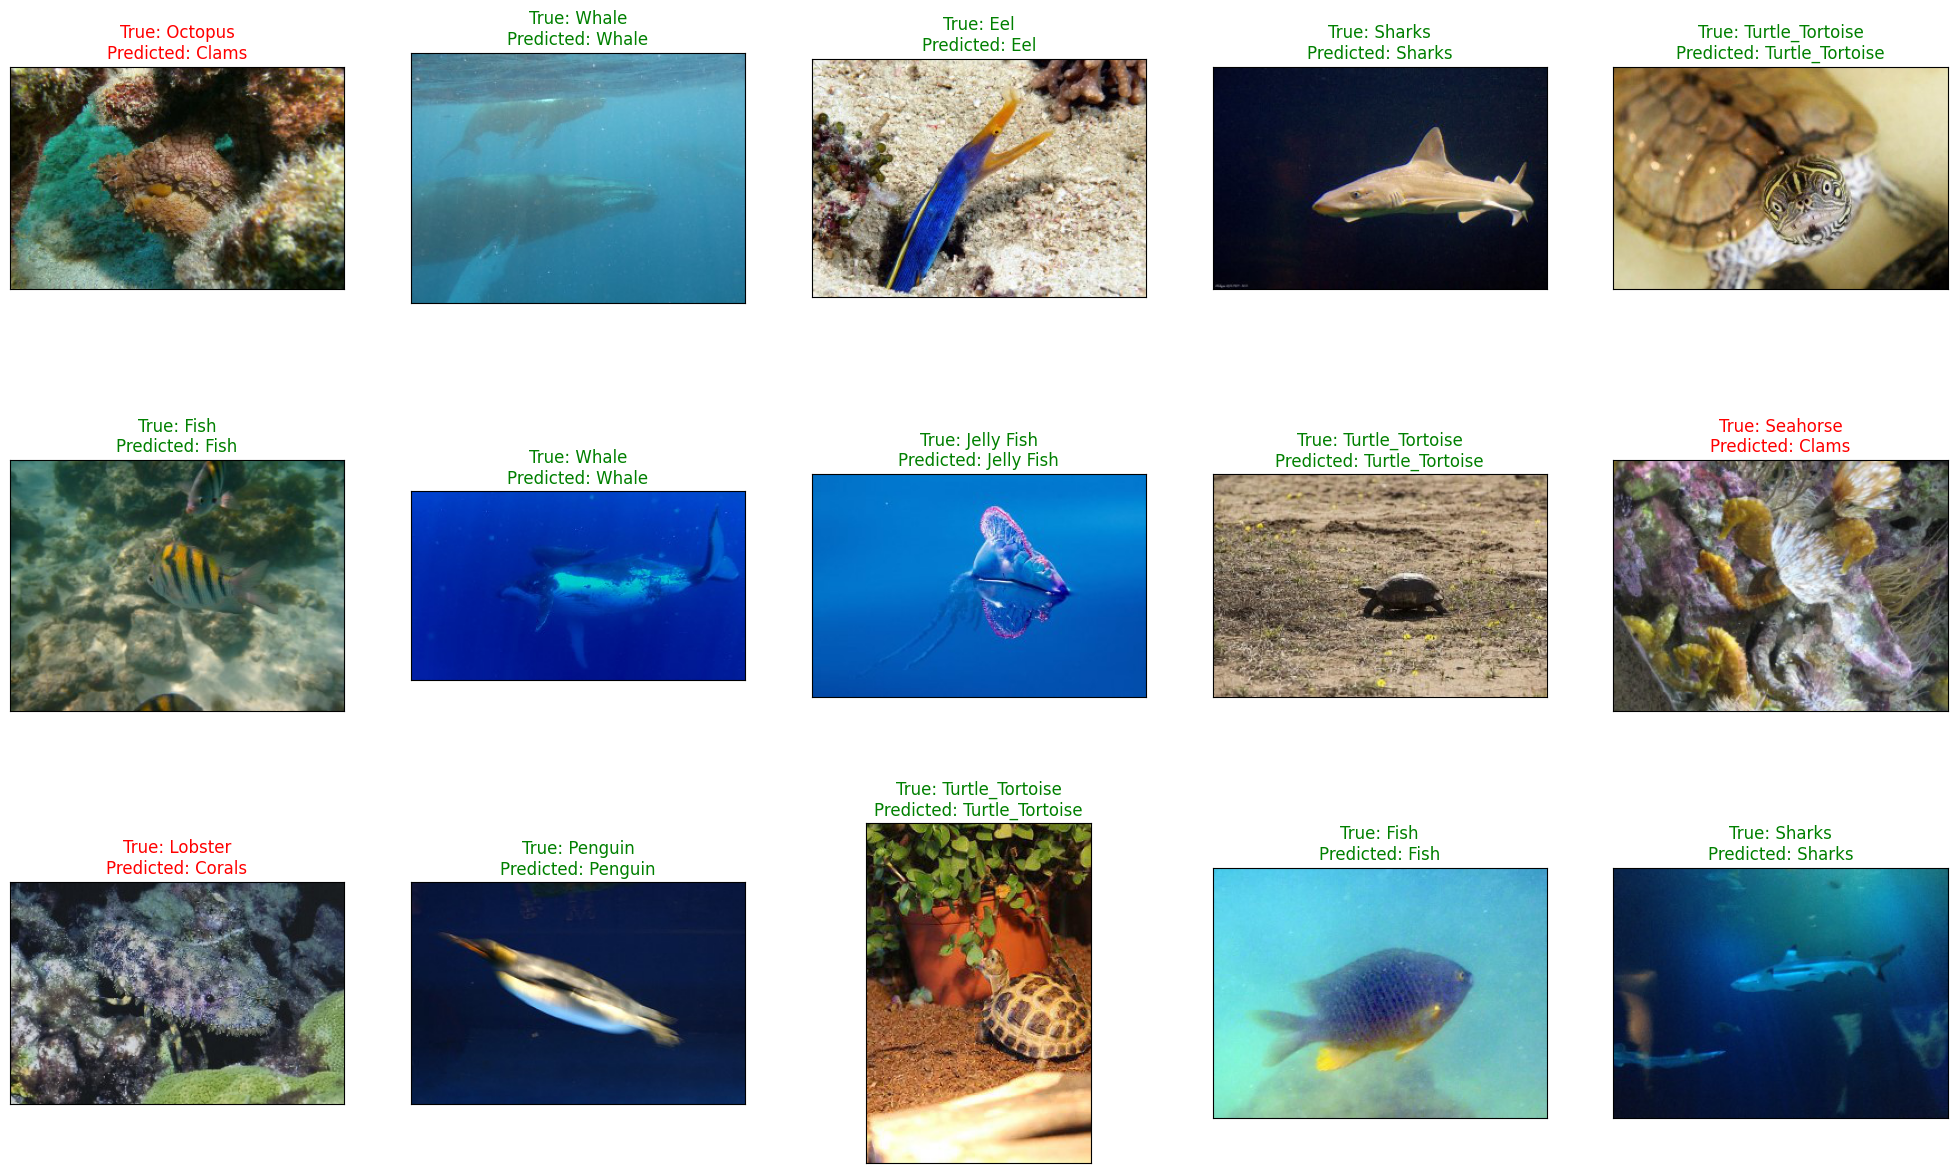

<Figure size 640x480 with 0 Axes>

In [56]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [57]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

          Clams       0.74      0.69      0.71       119
         Corals       0.66      0.73      0.70       111
          Crabs       0.97      0.97      0.97       112
        Dolphin       0.81      0.85      0.83       153
            Eel       0.62      0.73      0.67        93
           Fish       0.75      0.64      0.69       108
     Jelly Fish       0.92      0.93      0.92       179
        Lobster       0.91      0.72      0.80       100
    Nudibranchs       0.81      0.81      0.81       100
        Octopus       0.58      0.69      0.63       111
          Otter       1.00      1.00      1.00       102
        Penguin       0.93      0.88      0.90        97
        Puffers       0.80      0.65      0.72        99
       Sea Rays       0.79      0.71      0.75       116
    Sea Urchins       0.97      0.97      0.97       110
       Seahorse       0.75      0.79      0.77        91
           Seal       0.86    

In [58]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Clams             0.738739  0.689076  0.713043   119.000000
Corals            0.663934  0.729730  0.695279   111.000000
Crabs             0.973214  0.973214  0.973214   112.000000
Dolphin           0.807453  0.849673  0.828025   153.000000
Eel               0.623853  0.731183  0.673267    93.000000
Fish              0.750000  0.638889  0.690000   108.000000
Jelly Fish        0.917127  0.927374  0.922222   179.000000
Lobster           0.911392  0.720000  0.804469   100.000000
Nudibranchs       0.810000  0.810000  0.810000   100.000000
Octopus           0.583333  0.693694  0.633745   111.000000
Otter             1.000000  1.000000  1.000000   102.000000
Penguin           0.934066  0.876289  0.904255    97.000000
Puffers           0.800000  0.646465  0.715084    99.000000
Sea Rays          0.788462  0.706897  0.745455   116.000000
Sea Urchins       0.972727  0.972727  0.972727   110.000000
Seahorse          0.750000  0.791209  0.770053    91.000000
Seal              0.857143  0.779221  0.816327    77.000000
Sharks            0.703125  0.775862  0.737705   116.000000
Shrimp            0.662791  0.647727  0.655172    88.000000
Squid             0.777778  0.786517  0.782123    89.000000
Starfish          0.970588  0.970588  0.970588   102.000000
Turtle_Tortoise   0.928375  0.973988  0.950635   346.000000
Whale             0.778689  0.766129  0.772358   124.000000
accuracy          0.822093  0.822093  0.822093     0.822093
macro avg         0.813165  0.802454  0.805902  2743.000000
weighted avg      0.825600  0.822093  0.822151  2743.000000

In [59]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


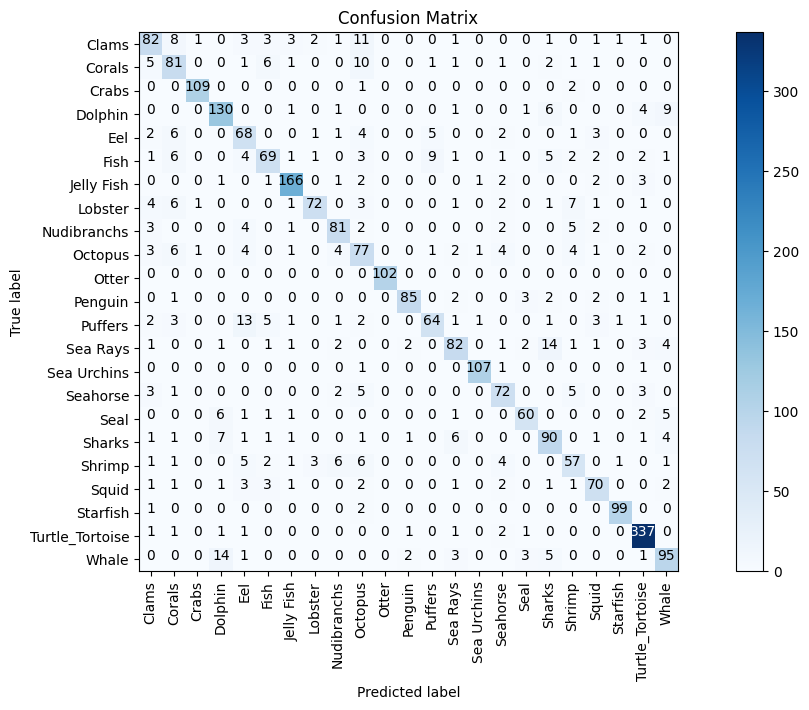

In [60]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [61]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-61-ccc8f9e1384d>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


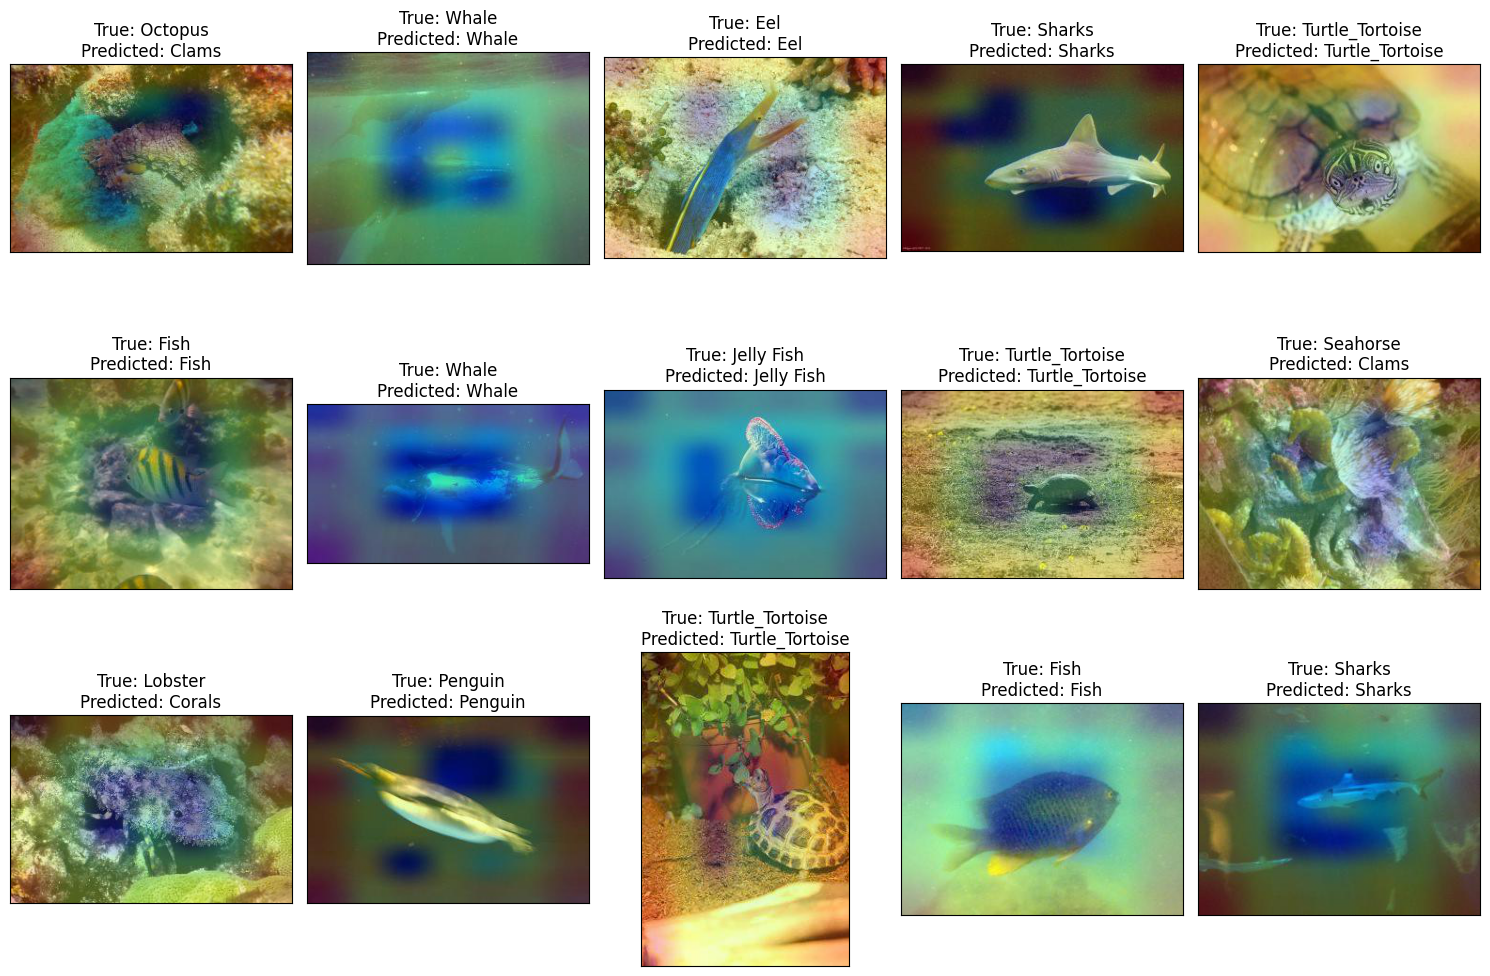

In [62]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()